## Кривоногов Н.В., NLP, практическое задание № 12 - 3

In [1]:
!wget -q https://www.dropbox.com/s/43l702z5a5i2w8j/gazeta_train.txt
!wget -q https://www.dropbox.com/s/k2egt3sug0hb185/gazeta_val.txt
!wget -q https://www.dropbox.com/s/3gki5n5djs9w0v6/gazeta_test.txt

In [2]:
!ls

gazeta_test.txt  gazeta_train.txt  gazeta_val.txt  sample_data


In [3]:
!pip install razdel networkx pymorphy2[fast] nltk rouge==0.3.1 summa lexrank sumy
!pip install --upgrade datasets razdel spacy networkx seaborn scipy tqdm tensorflow-text
!python -m spacy download ru_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 23.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.1/371.1 kB 43.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 63.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for summa: filename=summa-1.2.0-py3-none-any

## Загрузим данные с помощью библиотеки datasets

In [4]:
# по сути данные те же можно пользоваться любым способом загрузки
from datasets import load_dataset

dataset = load_dataset('IlyaGusev/gazeta', revision="v1.0")["test"]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/52400 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5770 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5265 [00:00<?, ? examples/s]

## EDA (Exploratory data analysis)

### Dataset

Посмотрим на то, как устроен датасет

In [5]:
!head -n 1 gazeta_train.txt
!cat gazeta_train.txt | wc -l
!cat gazeta_val.txt | wc -l
!cat gazeta_test.txt | wc -l

{"url": "https://www.gazeta.ru/financial/2011/11/30/3852658.shtml", "text": "«По итогам 2011 года чистый отток может составить примерно $80 млрд, в следующем году — около $20 млрд. При этом мы ожидаем, что со второго полугодия 2012 года начнется приток капитала», — заявил «Интерфаксу» замминистра экономического развития Андрей Клепач. Официальные прогнозы по выводу капитала из России становятся все пессимистичными: еще летом власти полагали, что из страны уйдет не более $35 млрд, в сентябре Минэкономразвития назвал цифру $50 млрд, в начале ноября Центробанк пересмотрел оценку до $70 млрд. Очередное изменение прогноза было ожидаемо: по расчетам Центробанка , за январь — октябрь чистый отток капитала достиг $64 млрд, причем в последние месяцы он ускорился: в сентябре он составил $14 млрд, в октябре — $13 млрд против среднего ежемесячного оттока в $6—8 млрд в первом полугодии. «После октябрьских данных Минэкономразвития вынуждено было изменить оценку, настаивать на $70 млрд означало ожида

In [6]:
import json
import random

def read_gazeta_records(file_name, shuffle=True, sort_by_date=False):
    assert shuffle != sort_by_date
    records = []
    with open(file_name, "r") as r:
        for line in r:
            records.append(json.loads(line))
    if sort_by_date:
        records.sort(key=lambda x: x["date"])
    if shuffle:
        random.shuffle
    return records

In [7]:
train_records = read_gazeta_records("gazeta_train.txt")
val_records = read_gazeta_records("gazeta_val.txt")
test_records = read_gazeta_records("gazeta_test.txt")

In [8]:
test_records[0]

{'url': 'https://www.gazeta.ru/science/2020/02/14_a_12960289.shtml',
 'text': 'Американское аэрокосмическое агентство NASA огласило названия четырех космических миссий, которые в скором времени могут быть выбраны для реализации и запуск которых может состояться уже в конце этого десятилетия. Эти четыре проекта стали полуфиналистами конкурса, объявленного среди американских научных команд, в котором участвовало более десяти миссий. Все они были отобраны по критериям потенциальной пользы для науки и технической осуществимости проекта. В рамках программы Discovery NASA занимается планированием миссий, которые призваны дать ответы на фундаментальные вопросы о происхождении тел Солнечной системы и возможному наличию жизни на них. «Эти выбранные миссии могут трансформировать наше восприятие некоторых из наиболее активных и сложных миров в Солнечной системе, — заявил Томас Зурбучен, помощник директора NASA по науке. — Исследование каждого из этих небесных тел поможет раскрыть секреты о том, к

In [9]:
train_records[0].keys()

dict_keys(['url', 'text', 'title', 'summary', 'date'])

In [10]:
print(min([record["date"] for record in train_records]), end=' - ')
print(max([record["date"] for record in train_records]))
print(min([record["date"] for record in val_records]), end=' - ')
print(max([record["date"] for record in val_records]))
print(min([record["date"] for record in test_records]), end=' - ')
print(max([record["date"] for record in test_records]))

2010-06-01 10:35:49 - 2019-05-31 23:56:26
2019-06-01 08:30:00 - 2019-09-30 23:11:23
2019-10-01 08:23:02 - 2020-03-23 22:16:23


### Statistics

In [12]:
!pip install pymorphy2

  Using cached pymorphy2-0.9.1-py3-none-any.whl (55 kB)
  Using cached pymorphy2_dicts_ru-2.4.417127.4579844-py2.py3-none-any.whl (8.2 MB)
  Using cached docopt-0.6.2-py2.py3-none-any.whl


In [13]:
from collections import Counter, namedtuple
import razdel
import pymorphy2

Stats = namedtuple("Stats", "vocabulary,lemma_vocabulary,words_counts,unique_words_counts")

def collect_stats(records, lower=True, text_max_words=3000, summary_max_words=100, nrows=1000):
    morph = pymorphy2.MorphAnalyzer()

    text_stats = Stats(Counter(),  Counter(), list(), list())
    summary_stats = Stats(Counter(),  Counter(), list(), list())

    def update_record_field_stats(field, stats, max_words):
        words = [word.text for word in razdel.tokenize(field)][:max_words]
        lemmas = [morph.parse(word)[0].normal_form for word in words]
        stats.vocabulary.update(words)
        stats.lemma_vocabulary.update(lemmas)
        stats.words_counts.append(len(words))
        stats.unique_words_counts.append(len(set(words)))

    for i, record in enumerate(records):
        if i >= nrows:
            break
        text = record["text"]
        text = text if not lower else text.lower()
        update_record_field_stats(text, text_stats, text_max_words)

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        summary_words = [word.text for word in razdel.tokenize(summary)]
        update_record_field_stats(summary, summary_stats, summary_max_words)
    return text_stats, summary_stats

In [14]:
train_text_stats, train_summary_stats = collect_stats(train_records)
print("Train texts vocabulary size: ", len(train_text_stats.vocabulary))
print("Train texts lemma vocabulary size: ", len(train_text_stats.lemma_vocabulary))
print("Train summaries vocabulary size: ", len(train_summary_stats.vocabulary))
print("Train summaries lemma vocabulary size: ", len(train_summary_stats.lemma_vocabulary))
print("Train common lemmas summary vs text: ", len(set(train_text_stats.lemma_vocabulary.keys()) & set(train_summary_stats.lemma_vocabulary.keys())))

Train texts vocabulary size:  82978
Train texts lemma vocabulary size:  37851
Train summaries vocabulary size:  15441
Train summaries lemma vocabulary size:  9030
Train common lemmas summary vs text:  8652


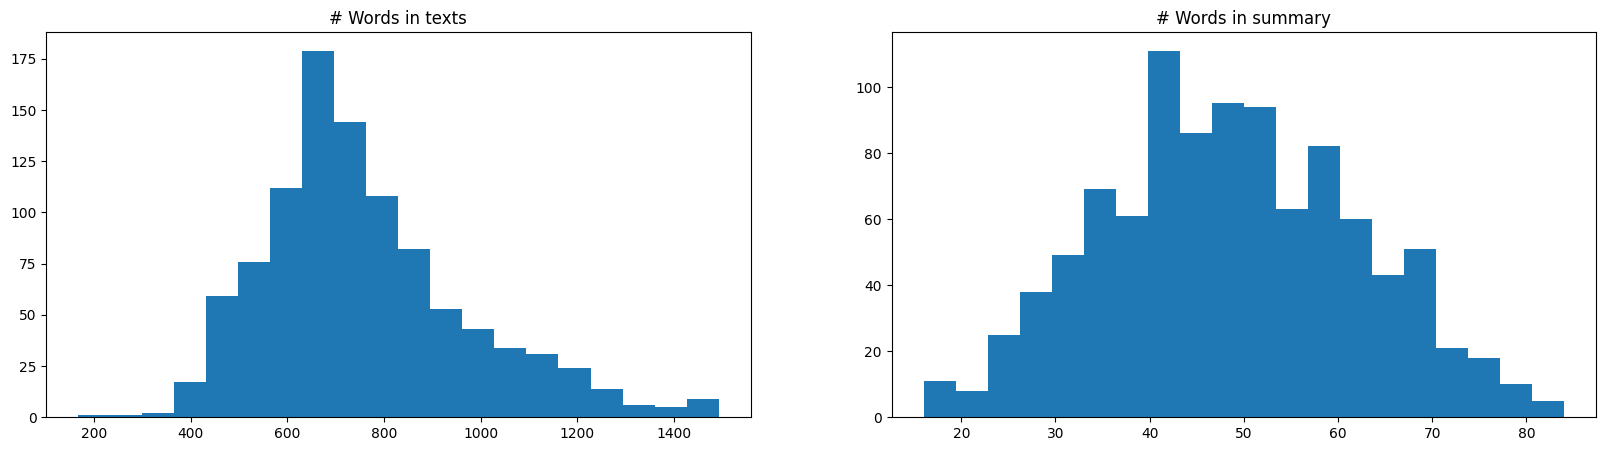

In [15]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].hist(train_text_stats.words_counts, 20)
axs[0].set_title('# Words in texts')

axs[1].hist(train_summary_stats.words_counts, 20)
axs[1].set_title('# Words in summary')
plt.show()

## Lead-3

Первый baseline - первые 3 предложения текста в качестве summary.


В качестве метрик здесь и далее используем BLEU и [ROUGE](https://).<br><br>

* **ROUGE-N** – measures unigram, bigram, trigram and higher order n-gram overlap
* **ROUGE-L** – measures longest matching sequence of words using LCS. An advantage of using LCS is thatit does not require consecutive matches but in-sequence matches that reflect sentence level wordorder. Since it automatically includes longest in-sequence common n-grams, you don’t need apredefined n-gram length.

In [17]:
!pip install rouge

In [18]:
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge

def calc_scores(references, predictions, metric="all"):
    print("Count:", len(predictions))
    print("Ref:", references[-1])
    print("Hyp:", predictions[-1])

    if metric in ("bleu", "all"):
        print("BLEU: ", corpus_bleu([[r] for r in references], predictions))
    if metric in ("rouge", "all"):
        rouge = Rouge()
        scores = rouge.get_scores(predictions, references, avg=True)
        print("ROUGE: ", scores)

In [19]:
import razdel

def calc_lead_n_score(records, n=3, lower=True, nrows=1000):
    references = []
    predictions = []

    for i, record in enumerate(records):
        if i >= nrows:
            break

        summary = record["summary"]
        summary = summary if not lower else summary.lower()
        references.append(summary)

        text = record["text"]
        text = text if not lower else text.lower()
        sentences = [sentence.text for sentence in razdel.sentenize(text)]
        prediction = " ".join(sentences[:n])
        predictions.append(prediction)

    calc_scores(references, predictions)

calc_lead_n_score(test_records, n=1)

Count: 1000
Ref: телеканал «спас» запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер. организаторы отметили, что это беспрецедентный подобный проект на телевидении. участникам шоу будет, где поработать — в монастыре работают свечной, молочный и столярный цеха, есть коровник, конюшня, пасека.
Hyp: православный телеканал «спас», учредителем которого является московская патриархия, запускает реалити-шоу «остров», участникам которого предстоит месяц жить и работать в нило-столобенской пустыни на озере селигер в тверской области.
BLEU:  0.19177311186434495
ROUGE:  {'rouge-1': {'r': 0.37762764047433917, 'p': 0.22208274285774904, 'f': 0.23804097238957525}, 'rouge-2': {'r': 0.15833772153385062, 'p': 0.09647636782929753, 'f': 0.10027796832321115}, 'rouge-l': {'r': 0.34937017731940756, 'p': 0.2022959168891477, 'f': 0.21799992093276083}}


## Метод Луна

Метод Луна — первый эвристический метод автоматического реферирования. Он был описан в 1958 году в статье Ханса Петера Луна и реализован на IBM 704.

В современных терминах алгоритм звучит так:


* Вычисляем значимые слова документа:
    * Делаем стемминг или лемматизацию слов: разные словоформы одной леммы должны считаться как одно слово.
    * Считаем частоты слов, формируем список слов по убыванию частоты.
    * Убираем стоп-слова: частотные слова, у которых нет отдельной смысловой нагрузки, например предлоги и частицы.
    * Убираем слишком редкие слова, например такие, которые встречаются только 1 раз, либо убираем какой-то перцентиль слов по частоте.
    * Все оставшиеся слова считаем значимыми.
* Считаем значимость для предложений:
    * Предложение делим на промежутки, которые начинаются и заканчиваются значимыми словами. В промежутке могут быть и незначимые слова, но не более 4 подряд.
    * Значимость промежутка — квадрат количества значимых слов в промежутке, делённый на размер промежутка.
    * Значимость предложения — максимум из значимостей промежутков.
* Берём в качестве реферата предложения со значимостью выше определённого порога.

Пример вычисления значимости предложения приведён на рисунке ниже. Красным обозначены стоп-слова, фиолетовым — незначимые слова, а зелёным — значимые слова.



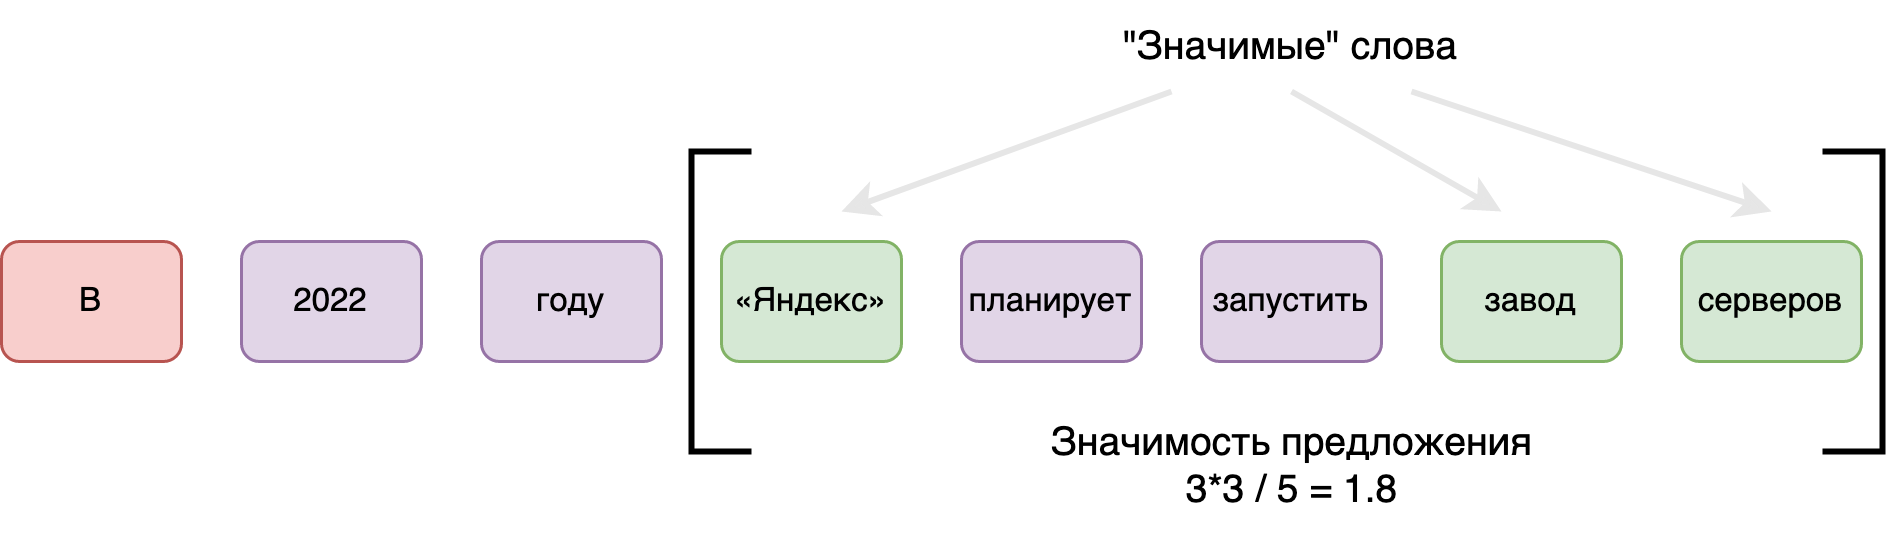

Несмотря на свою простоту, метод Луна до сих используется в современных программных комплексах.


In [20]:
# Делаем предобработку

import razdel
import spacy

# Список частей речи, которые мы не хотим считать значимыми.
# Подбирался на глаз.
BAD_POS = ("PREP", "NPRO", "CONJ", "PRCL", "NUMR", "PRED", "INTJ", "PUNCT", "CCONJ", "ADP", "DET", "ADV")

# Загрузка модели для частеречной разметки.
spacy_model = spacy.load("ru_core_news_md")


# Метод для разбиения текста на предложения.
def sentenize(text):
    return [s.text for s in razdel.sentenize(text)]


# Метод для токенизации предложения.
def tokenize_sentence(sentence):
    sentence = sentence.strip().replace("\xa0", "")
    tokens = [token.lemma_ for token in spacy_model(sentence) if token.pos_ not in BAD_POS]
    tokens = [token for token in tokens if len(token) > 2]
    return tokens


# Метод для токенизации всего текста.
def tokenize_text(text):
    all_tokens = []
    for sentence in sentenize(text):
        all_tokens.extend(tokenize_sentence(sentence))
    return all_tokens


# Пример работы обоих методов.
text = test_records[0]["text"]
sentences = sentenize(text)
print(tokenize_sentence(sentences[0]))
print(tokenize_text(text))

['американский', 'аэрокосмический', 'агентство', 'nasa', 'огласить', 'название', 'четыре', 'космический', 'миссия', 'которые', 'скорый', 'время', 'мочь', 'быть', 'выбрать', 'реализация', 'запуск', 'которых', 'мочь', 'состояться', 'конец', 'десятилетие']
['американский', 'аэрокосмический', 'агентство', 'nasa', 'огласить', 'название', 'четыре', 'космический', 'миссия', 'которые', 'скорый', 'время', 'мочь', 'быть', 'выбрать', 'реализация', 'запуск', 'которых', 'мочь', 'состояться', 'конец', 'десятилетие', 'четыре', 'проект', 'стать', 'полуфиналист', 'конкурс', 'объявить', 'американский', 'научный', 'команда', 'котором', 'участвовать', 'десять', 'миссия', 'они', 'были', 'отобрать', 'критерий', 'потенциальный', 'польза', 'наука', 'технический', 'осуществимость', 'проект', 'рамка', 'программа', 'discovery', 'nasa', 'заниматься', 'планирование', 'миссия', 'которые', 'призваны', 'дать', 'ответ', 'фундаментальный', 'вопрос', 'происхождение', 'тело', 'солнечный', 'система', 'возможный', 'наличие

In [21]:
from collections import Counter

class LuhnSummarizer:
    """
    Метод Луна.
    Основано на https://github.com/miso-belica/sumy/blob/main/sumy/summarizers/luhn.py
    Оригинальная статья: https://courses.ischool.berkeley.edu/i256/f06/papers/luhn58.pdf
    """
    def __init__(
        self,
        significant_percentage = 0.4, # 40% самых частотных токенов мы считаем значимыми.
        min_token_freq = 2, # Кроме того, слова должны встречаться минимум 2 раза.
        max_gap_size = 4, # Максимальное количество подряд идущих незначимых токенов в промежутках.
        verbose = False # Отладочный вывод для наглядности.
    ):
        self.significant_percentage = significant_percentage
        self.min_token_freq = min_token_freq
        self.max_gap_size = max_gap_size
        self.chunk_ending_mask = [0] * self.max_gap_size
        self.verbose = verbose

    def __call__(self, text, target_sentences_count):
        # Считаем значимые токены.
        all_significant_tokens = self._get_significant_tokens(text)
        if self.verbose:
            print("Значимые токены: ", all_significant_tokens)

        # Считаем значимости предложений.
        ratings = []
        for sentence_index, sentence in enumerate(sentenize(text)):
            # Значимость предложений - максимум из значимостей промежутков.
            sentence_rating = max(self._get_chunk_ratings(sentence, all_significant_tokens))
            if self.verbose:
                print("\tПРЕДЛОЖЕНИЕ. Значимость: {}, текст: {}".format(sentence_rating, sentence))
            ratings.append((sentence_rating, sentence_index))

        # Сортируем предложения по значимости.
        ratings.sort(reverse=True)

        # Оставляем топовые и собираем реферат.
        ratings = ratings[:target_sentences_count]
        indices = [index for _, index in ratings]
        indices.sort()
        return " ".join([sentences[index] for index in indices])

    def _get_significant_tokens(self, text):
        """ Метод для подсчёта того, какие токены являются значимыми. """
        tokens_counter = Counter(tokenize_text(text))
        significant_tokens_max_count = int(len(tokens_counter) * self.significant_percentage)
        significant_tokens = tokens_counter.most_common(significant_tokens_max_count)
        significant_tokens = {token for token, cnt in significant_tokens if cnt >= self.min_token_freq}
        return significant_tokens

    def _get_chunk_ratings(self, sentence, significant_tokens):
        """ Разбиваем предложение на промежтуки и считаем их значимости. """

        tokens = tokenize_sentence(sentence)

        chunks, masks = [], []
        in_chunk = False
        for token in tokens:
            is_significant_token = token in significant_tokens

            if is_significant_token and not in_chunk:
                in_chunk = True
                masks.append([int(is_significant_token)])
                chunks.append([token])
            elif in_chunk:
                last_mask = masks[-1]
                last_mask.append(int(is_significant_token))
                last_chunk = chunks[-1]
                last_chunk.append(token)
            if not chunks:
                continue

            # Проверяем на наличие 4 подряд идущих незначимых токенов.
            # Если встретили - завершаем промежуток.
            last_chunk_ending_mask = masks[-1][-self.max_gap_size:]
            if last_chunk_ending_mask == self.chunk_ending_mask:
                in_chunk = False

        ratings = []
        for chunk, mask in zip(chunks, masks):
            rating = self._get_chunk_rating(mask, chunk)
            ratings.append(rating)
        return ratings

    def _get_chunk_rating(self, original_mask, chunk):
        """ Подсчёт значимости одного промежутка """

        # Убираем незначимые токены в конце промежутка
        original_mask = "".join(map(str, original_mask))
        mask = original_mask.rstrip("0")

        end_index = original_mask.rfind("1") + 1
        chunk = chunk[:end_index]
        assert len(mask) == len(chunk)
        chunk = " ".join(chunk)

        # Считаем значимость
        words_count = len(mask)
        assert words_count > 0
        significant_words_count = mask.count("1")
        assert significant_words_count > 0

        rating = significant_words_count * significant_words_count / words_count
        if self.verbose:
            print("ПРОМЕЖУТОК. Значимость: {}, маска: {}, текст: {}".format(rating, mask, chunk))
        return rating

In [22]:
luhn = LuhnSummarizer(verbose=False)
summary = luhn(text, 3)
print()
print("Текст: {}".format(test_records[0]["text"]))
print("Итоговый реферат: {}".format(summary))
print("Правильный реферат: {}".format(test_records[0]["summary"]))


Текст: Американское аэрокосмическое агентство NASA огласило названия четырех космических миссий, которые в скором времени могут быть выбраны для реализации и запуск которых может состояться уже в конце этого десятилетия. Эти четыре проекта стали полуфиналистами конкурса, объявленного среди американских научных команд, в котором участвовало более десяти миссий. Все они были отобраны по критериям потенциальной пользы для науки и технической осуществимости проекта. В рамках программы Discovery NASA занимается планированием миссий, которые призваны дать ответы на фундаментальные вопросы о происхождении тел Солнечной системы и возможному наличию жизни на них. «Эти выбранные миссии могут трансформировать наше восприятие некоторых из наиболее активных и сложных миров в Солнечной системе, — заявил Томас Зурбучен, помощник директора NASA по науке. — Исследование каждого из этих небесных тел поможет раскрыть секреты о том, как они и им подобные объекты образовались в космосе». Каждый проект из 